In [ ]:
!pip install ipywidgets

In [2]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [3]:
from ipywidgets import VBox, Button, FileUpload, Output, Label
from PIL import Image
from IPython.display import display
import io
import numpy as np
import torchvision.transforms as T
import torch

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [6]:
# Decide which model to use among the ones exported
try:
    learn_inf = torch.jit.load("transfer_exported.pt")
except:
    print("Error loading model. Make sure model path is correct.")

# TODO: Make sure to set class_names attribute in your learn_inf model
# learn_inf.class_names = ["class1", "class2", ..., "classN"]

def on_click_classify(change):
    try:
        # Load image that has been uploaded
        fn = io.BytesIO(btn_upload.data[-1])
        img = Image.open(fn)
        img.load()
    except:
        print("Error reading image. Make sure to upload a valid image.")
        return

    # Clear the previous output (if any)
    out_pl.clear_output()

    # Display the image
    with out_pl:
        ratio = img.size[0] / img.size[1]
        c = img.copy()
        c.thumbnail([ratio * 200, 200])
        display(c)

    # Transform to tensor
    img=img.convert("RGB")
    timg = T.ToTensor()(img).unsqueeze_(0)

    # Calling the model
    try:
        softmax = learn_inf(timg).data.cpu().numpy().squeeze()
    except Exception as e:
        print("Error during model inference:", e)
        return

    # Get the indexes of the classes ordered by softmax (larger first)
    idxs = np.argsort(softmax)[::-1]

    # Loop over the classes with the largest softmax
    for i in range(5):
        p = softmax[idxs[i]]
        landmark_name = learn_inf.class_names[idxs[i]]  # Make sure class_names is set
        labels[i].value = f"{landmark_name} (prob: {p:.2f})"

btn_upload = FileUpload()
btn_run = Button(description="Classify")
btn_run.on_click(on_click_classify)

labels = [Label() for _ in range(5)]
out_pl = Output()
out_pl.clear_output()

wgs = [Label("Please upload a picture of a landmark"), btn_upload, btn_run, out_pl]
wgs.extend(labels)

VBox(wgs)

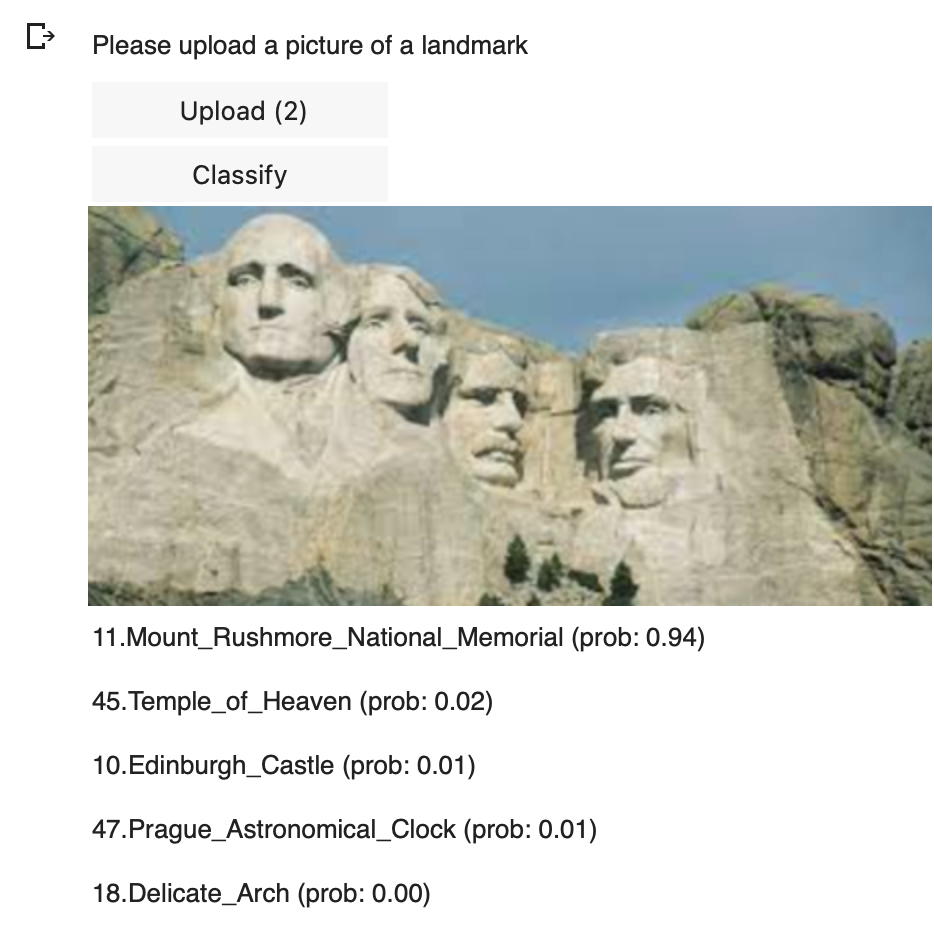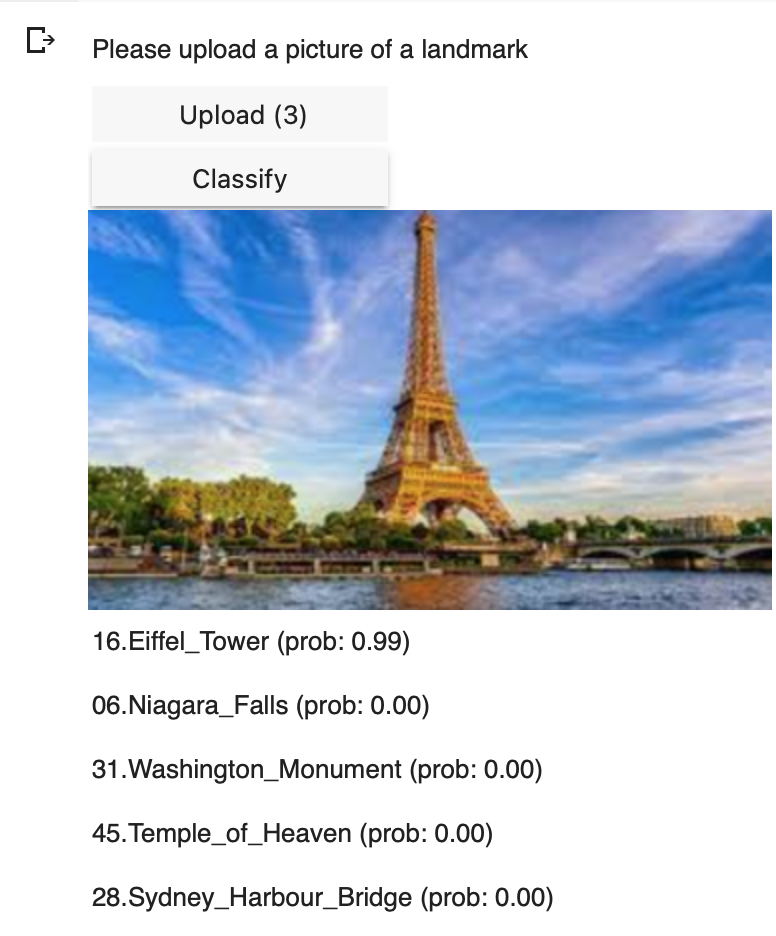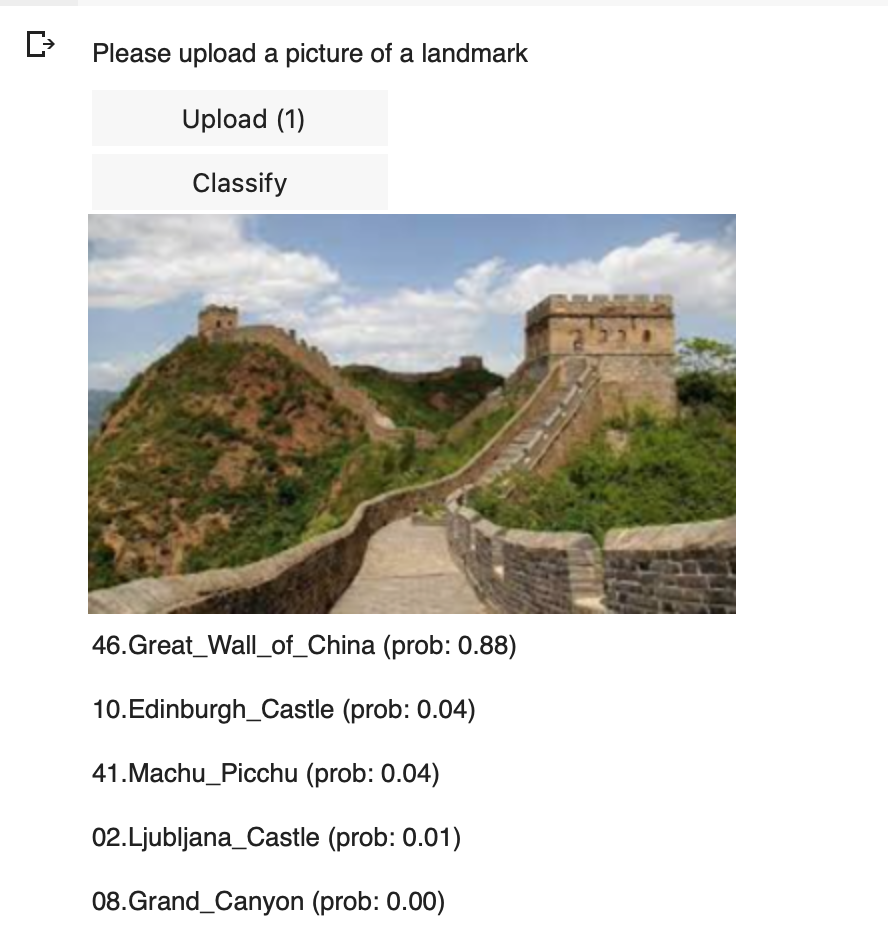